# I/O: FITS and ASCII

In this section we will:

- Learn how to use FITS files
    - <a href="#Working-with-FITS-files">Open a FITS file</a>
    - <a href="#Working-with-headers">Examine its header</a>
    - <a href="#Working-with-image-data">Image data</a>
    - <a href="#Working-with-FITS-tables">Table data</a>
    - Visualizing with `matplotlib` and `astropy.visualization`
- Learn how to use ASCII files
    - <a href="#Working-with-ASCII-files">Open an ASCII file</a>
    - Visualizing with `matplotlib` and `astropy.visualization`
    
**For more information, see the Astropy documentation on [FITS](https://docs.astropy.org/en/stable/io/fits/) and [ASCII](https://docs.astropy.org/en/stable/io/ascii/index.html).**

---

# Working with FITS files

In [1]:
from astropy.io import fits

The `open()` function in [astropy.io.fits](https://docs.astropy.org/en/stable/io/fits/index.html) works with regular and compressed files.

Open a FITS file and look at the contents:

In [2]:
with fits.open('j94f05bgq_flt.fits.gz') as f:
    f.info()

Filename: j94f05bgq_flt.fits.gz
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     240   ()      
  1  SCI           1 ImageHDU       195   (1, 1)   float32   
  2  ERR           1 ImageHDU        69   ()      
  3  DQ            1 ImageHDU        69   ()      
  4  SCI           2 ImageHDU       184   (1, 1)   float32   
  5  ERR           2 ImageHDU        69   ()      
  6  DQ            2 ImageHDU        69   ()      


Opening a FITS file using the Python *with* statement
ensures that the file is closed without explicitly doing so.

There is also a shortcut to look inside a FITS file before fully opening it:

In [3]:
fits.info('j94f05bgq_flt.fits.gz')

Filename: j94f05bgq_flt.fits.gz
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     240   ()      
  1  SCI           1 ImageHDU       195   (1, 1)   float32   
  2  ERR           1 ImageHDU        69   ()      
  3  DQ            1 ImageHDU        69   ()      
  4  SCI           2 ImageHDU       184   (1, 1)   float32   
  5  ERR           2 ImageHDU        69   ()      
  6  DQ            2 ImageHDU        69   ()      


In [20]:
type(f)

astropy.io.fits.hdu.hdulist.HDUList

FITS file objects, `HDUList`s,  are like lists. Individual HDUs are indexed like lists:

In [21]:
f[1]

Or by using a (EXTNAME, EXTVER) tuple.

In [22]:
f[("SCI", 1)]

## Working with headers

Headers are similar to Python dictionaries. Here, we will look at a header, modify an existing keyword, and add a new card.

In [23]:
keyname = 'CRPIX1'
extnum = 1

with fits.open('j94f05bgq_flt.fits.gz', mode='update') as f:
    value = f[extnum].header.get(keyname)  # None if non-existent
    print("{}: {}".format(keyname, value))
    f[extnum].header[keyname] = value + 1  # Reassign the keyword
    print("Updated {}: {}".format(keyname, f[extnum].header[keyname]))

CRPIX1: 12
Updated CRPIX1: 13


There are several ways to add a new header card.

Note: Attempting to access a non-existing keyword raises a *KeyError*.

In [24]:
f[extnum].header['observer'] = "Edwin Hubble"
f[extnum].header  # Scroll to the end to see OBSERVER

XTENSION= 'IMAGE   '           / Image extension                                
BITPIX  =                  -32 / Bits per pixel                                 
NAXIS   =                    2 / Number of axes                                 
NAXIS1  =                    1 / Axis length                                    
NAXIS2  =                    1 / Axis length                                    
PCOUNT  =                    0 / No 'random' parameters                         
GCOUNT  =                    1 / Only one group                                 
ORIGIN  = 'NOAO-IRAF FITS Image Kernel July 2003' / FITS file originator        
EXTNAME = 'SCI     '           / Extension name                                 
EXTVER  =                    1 / Extension version                              
DATE    = '2007-02-08T21:38:47' / Date FITS file was generated                  
IRAF-TLM= '13:38:23 (20/08/2008)' / Time of last modification                   
INHERIT =                   

In [25]:
# Use "insert()" to control where to insert the new keyword.
# Here, the tuple is (KEYWORD, VALUE, COMMENT).
f[extnum].header.insert('OBSERVER', ('NOBS', 2, "Number of observing nights"))
f[extnum].header  # Scroll to the end to see NOBS inserted before OBSERVER

XTENSION= 'IMAGE   '           / Image extension                                
BITPIX  =                  -32 / Bits per pixel                                 
NAXIS   =                    2 / Number of axes                                 
NAXIS1  =                    1 / Axis length                                    
NAXIS2  =                    1 / Axis length                                    
PCOUNT  =                    0 / No 'random' parameters                         
GCOUNT  =                    1 / Only one group                                 
ORIGIN  = 'NOAO-IRAF FITS Image Kernel July 2003' / FITS file originator        
EXTNAME = 'SCI     '           / Extension name                                 
EXTVER  =                    1 / Extension version                              
DATE    = '2007-02-08T21:38:47' / Date FITS file was generated                  
IRAF-TLM= '13:38:23 (20/08/2008)' / Time of last modification                   
INHERIT =                   

In [26]:
# FITS header keyword is also not case-sensitive.
print('observer:', f[extnum].header['OBSERVER'])
print('{}: {}'.format(f[extnum].header.comments['NOBS'], f[extnum].header['NOBS']))

observer: Edwin Hubble
Number of observing nights: 2


To delete a keyword/card, it is best to use the *remove* method, which does not raise an exception if the keyword is not present and `ignore_missing=True` option is provided.

In [27]:
f[extnum].header.remove('NOBS', ignore_missing=True)
f[extnum].header.remove('observer', ignore_missing=True)

Comment and history cards are added with special methods. In this case, a new card is always created.

In [28]:
import time

with fits.open('j94f05bgq_flt.fits.gz', mode='update') as f:
    f[extnum].header.add_history('{} New history card.'.format(time.ctime()))
    f[extnum].header.add_comment('This is a cool image.')
    f[extnum].header.add_comment('Much science. So Python.')
    print(f[extnum].header['comment'])
    print()
    print(f[extnum].header['history'])

This is a 47 Tuc observation with HST
I'd like to observe it with JWST.
This is a cool image.
Much science. So Python.

The following throughput tables were used: crotacomp$hst_ota_007_syn.fit
s, cracscomp$acs_wfc_im123_004_syn.fits, cracscomp$acs_f606w_005_syn.fit
s, cracscomp$acs_wfc_ebe_win12f_005_syn.fits, cracscomp$acs_wfc_ccd1_017
_syn.fits
A test history cars
A test history card
New history card.
New history card.
New history card.
New history card.
New history card.
New history card.
New history card.
Sun Feb  4 20:18:37 2024 New history card.


## Working with image data

In [29]:
with fits.open('pix.fits.gz') as f:
    f.info()
    scidata = f[0].data.copy()

Filename: pix.fits.gz
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      53   (512, 512)   int16   


An image is a NumPy array saved as the data part of an HDU.

In [30]:
print(scidata.shape)
print(scidata.dtype)

(512, 512)
>i2


`scidata` is a copy of the data array of the HDU. If it changes, it will not affect the data in the FITS file.

In [31]:
# All operations available to NDArray are applicable to the FITS data array.
scidata[2:10, 3:7].mean()

38.375

`astropy.io.fits` provides convenience functions to operate on FITS files. These are good for interactive and quick lookup use. It is recommended to use the object-oriented interface for programming (creating a FITS object that you operate on above).

In [32]:
# Get the data from an HDU.
data = fits.getdata('pix.fits.gz')
print("min: {}, max: {}".format(data.min(), data.max()))

min: -1, max: 19936


In [33]:
# Get a keyword value.
wcsaxes = fits.getval('j94f05bgq_flt.fits.gz', keyword="WCSAXES", ext=1)
print("WCSAXES:", wcsaxes)

WCSAXES: 2


In [34]:
# Set a keyword value.
fits.setval("j94f05bgq_flt.fits.gz", keyword="observer", value="Jodie Foster")

print("OBSERVER: ", fits.getval("j94f05bgq_flt.fits.gz", keyword="OBSERVER"))

OBSERVER:  Jodie Foster


In [35]:
# Remove a keyword from a header.
fits.delval("j94f05bgq_flt.fits.gz", keyword="OBSERVER")

### Visualizing with `matplotlib`

In [36]:
from astropy.visualization import imshow_norm, PercentileInterval, LogStretch
from matplotlib import pyplot as plt

%matplotlib inline

For astronomical images, you can use `astropy.visualization` to [normalize and stretch](https://docs.astropy.org/en/stable/visualization/normalization.html) the display. (`astropy.visualization` will be covered more in a later section.) Here, we want it to be logarithmic.

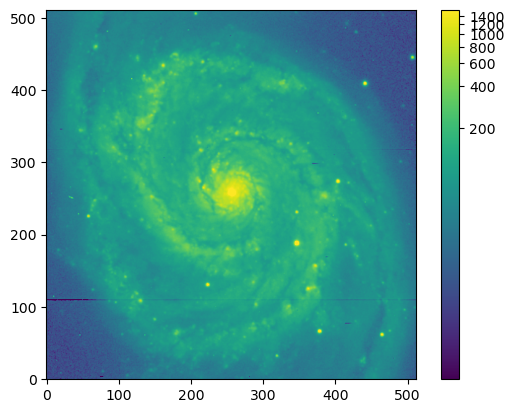

In [37]:
# Display the image (you can ignore the warnings if you see them)
fig, ax = plt.subplots()
im, norm = imshow_norm(
    scidata, ax, origin='lower',
        interval=PercentileInterval(99.9), stretch=LogStretch())
fig.colorbar(im)

`matplotlib` has a number of built-in colormaps that can be used to represent data. See all of the options on the [matplotlib website](https://matplotlib.org/examples/color/colormaps_reference.html). 

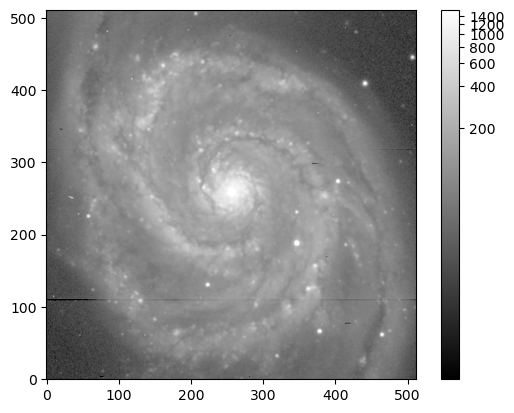

In [38]:
fig, ax = plt.subplots()
im, norm = imshow_norm(
    scidata, ax, origin='lower', cmap='gray',
    interval=PercentileInterval(99.9), stretch=LogStretch())
fig.colorbar(im)

## Working with FITS tables

**Note**: The recommended method to read and write a single FITS table is using the [Unified I/O read/write interface](https://docs.astropy.org/en/stable/io/unified.html#table-io-fits):

    from astropy.table import Table
    t = Table.read('data.fits')

We also show an example of using [astropy.io.fits](https://docs.astropy.org/en/stable/io/fits/index.html#) below as there is a lot of legacy code which uses it:

    with fits.open('data.fits') as hdu_list:
        hdu_list.info()
        table_data = hdu_list[1].data
        print('Column names: \n', table_data.names)
        print('\nRow 1: \n', table_data[1])
        print('\nColumn "time": \n', table_data.field('time'))
        print('\nNumber of rows: \n', len(table_data))

In [39]:
from astropy.table import QTable
from astropy.utils.data import download_file

In [40]:
table_filename = download_file('http://data.astropy.org/tutorials/FITS-tables/chandra_events.fits', cache=True)

In [41]:
# When a table contains columns with units, QTable can be used
# instead of Table.
tab = QTable.read(table_filename, hdu=1)

In [42]:
tab.colnames

['time',
 'ccd_id',
 'node_id',
 'expno',
 'chipx',
 'chipy',
 'tdetx',
 'tdety',
 'detx',
 'dety',
 'x',
 'y',
 'pha',
 'pha_ro',
 'energy',
 'pi',
 'fltgrade',
 'grade',
 'status']

In [43]:
tab[0]  # First row

time,ccd_id,node_id,expno,chipx,chipy,tdetx,tdety,detx,dety,x,y,pha,pha_ro,energy,pi,fltgrade,grade,status
s,,,,pix,pix,pix,pix,pix,pix,pix,pix,adu,adu,eV,chan,,,
float64,int16,int16,int32,float64,float64,float64,float64,float32,float32,float32,float32,float64,float64,float32,float64,int16,int16,bool[32]
238623220.9093583,3,3,68,920.0,8.0,5124.0,3981.0,5095.64111328125,4138.9951171875,4168.072265625,5087.77197265625,3548.0,3534.0,13874.71484375,951.0,16,4,False .. False


In [44]:
tab['time']

<Quantity [2.38623221e+08, 2.38623221e+08, 2.38623221e+08, ...,
           2.38672394e+08, 2.38672394e+08, 2.38672394e+08] s>

In [45]:
print("Number of rows:", len(tab))

Number of rows: 483964


### Visualizing with `matplotlib`
#### 1D Histogram

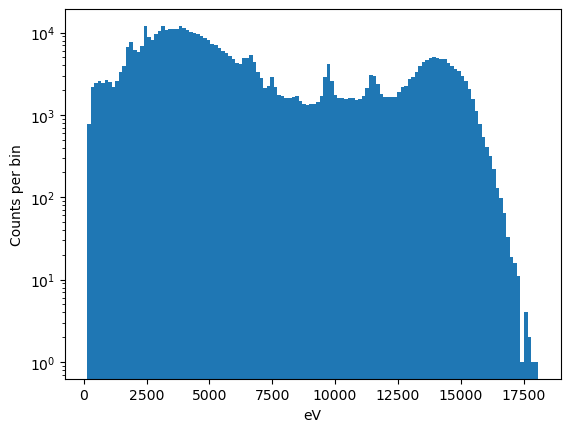

In [46]:
fig, ax = plt.subplots()
ax.hist(tab['energy'].value, bins=128, log=True)
ax.semilogy()
ax.set_xlabel("eV")

# The trailing ";" suppresses extraneous matplotlib output in notebook.
ax.set_ylabel("Counts per bin");

#### 2D Histogram

In [ ]:
from matplotlib.colors import LogNorm

fig, ax = plt.subplots()
h = ax.hist2d(tab['x'].value, tab['y'].value,
              bins=(1000, 1000), norm=LogNorm())
fig.colorbar(h[3]);

### Working with large files

The `open()` function supports a `memmap=True` option that allows the array data of each HDU to be accessed with memory mapping, rather than being read into memory all at once. This is particularly useful for working with very large arrays that cannot fit entirely into physical memory.

For more details, see https://astropy.readthedocs.io/en/stable/io/fits/index.html#working-with-large-files.

---
# Working with ASCII files

What if your data is in a text file? We've included `throughput.txt` as an example.

    Detector throughput values
    ——
    Wavelength_microns Throughput
    2.0004663860000003 1.7911368754631042e-12
    2.002074478 2.5344376991635788e-12
    2.00368257 3.3872207023255276e-12
    2.005290662 2.891853959468528e-12
    ...         ...

Python has a built-in method for opening text files like ASCII files, but it is not too friendly. Let's see how it works:

In [ ]:
with open('throughput.txt') as f:
    throughput_data = f.read()

print(type(throughput_data))
print(len(throughput_data))

# Now what? How do we extract the data?

Luckily, Astropy includes a package to handle ASCII files that immediately separates data into rows and columns, and loads it into an easy-to-use table:

In [ ]:
from astropy import units as u
from astropy.table import QTable

Since our file has a couple lines of comments at the top, we need to tell the reader to start reading the header at line 2 and the data at line 3. We will also rename the columns by passing in `names`.

In [ ]:
throughput_data = QTable.read(
    'throughput.txt', format='ascii.basic', data_start=3, header_start=2,
    names=['lambda', 'throughput'])

# Assign proper unit to wavelength column.
throughput_data['lambda'].unit = u.micron

throughput_data

Astropy's ASCII module can read files with a variety of formats and extensions, including comma-separated (CSV), tab-delimited, fixed-width, HTML, reStructuredText, and more. See the [Astropy docs](https://docs.astropy.org/en/stable/io/ascii/#supported-formats) for a complete list.

### Visualizing with `matplotlib`

In [ ]:
from astropy.visualization import quantity_support

with quantity_support():
    fig, ax = plt.subplots()
    ax.plot(throughput_data['lambda'], throughput_data['throughput'])
    ax.set_title('Some filter')